<a href="https://colab.research.google.com/github/marianelia/tmp/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Лагуткина |
|---------|--------|
| Группа  | 6      |

Вариант: 1

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

## Нейронная сеть 
### Установка библиотек и настройка среды


In [18]:
import torch
import numpy as np
import pandas
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

1.10.0+cu111


### Устанавливаем вычислительное устройство

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def print_device():
  print('Doing computations on '+device)

## Нейросеть


## Загрузка датасетов и подготовка данных

### Подготовительные функции

In [31]:
def convert_values(df):
    return np.array(df).astype(np.float32)/255


# TODO: замепнить на свои функции из 2.1
def count_of_keys(data):
    unique = np.unique(data)
    count = np.zeros(len(unique), dtype=np.int32)
    for v in data:
        count[v] += 1
    return count

def visualization_of_counts(df):
    counts = count_of_keys(df)
    plt.ylabel("Кол-во элементов в классе")
    plt.xlabel("Номер каждого класса")
    plt.bar(np.arange(len(counts)), counts)
    plt.xticks(np.arange(len(counts)), [i for i in range(len(counts))])

def print_data(labels, features, string :str, color_chart):
    visualization_of_counts(labels)
    print("{}".format(string))
    print("Number of elements in the dataset : {}".format(len(labels)))
    print("The number of attributes in the element : {}".format(len(features[0])))
    print()
    
def analyze(labels, features, string :str):
    visualization_of_counts(labels)
    print("Данные для [{}]".format(string))
    print("Количество элементов в датасете : {}".format(len(labels)))
    print("Количество атрибутов в элементе : {}".format(len(features[0])))
    print("Минимальное значение атрибута   : {}".format(np.min(features)))
    print("Максимальное значение атрибута  : {}".format(np.max(features)))
    print()

### MNIST

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Данные для [Обучающая выборка из MNIST]
Количество элементов в датасете : 60000
Количество атрибутов в элементе : 28
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0

Данные для [Тестовая выборка из MNIST]
Количество элементов в датасете : 10000
Количество атрибутов в элементе : 28
Минимальное значение атрибута   : 0.0
Максимальное значение атрибута  : 1.0



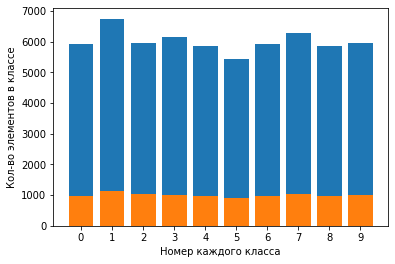

In [37]:
#transformations = transforms.Compose([
#  transforms.ToTensor(),
#  transforms.Normalize()                                         
#])
#TODO поставить свои функции
#Убрать кол-во элементов в атрибуте 
#Почему 28-то??
#TODO разбиение на выборки вынести в analize 
mnist_train = datasets.MNIST(root = './data/', train = True, transform = transforms.ToTensor(), download=True)
mnist_train_x = mnist_train.train_labels;
mnist_train_y_raw = mnist_train.train_data;

mnist_train_y = convert_values(mnist_train_y_raw)
analyze(mnist_train_x, mnist_train_y, "Обучающая выборка из MNIST")

mnist_test = datasets.MNIST(root = './data/', train = False,transform = transforms.ToTensor(), download=True)
mnist_test_x = mnist_test.train_labels;
mnist_test_y_raw = mnist_test.train_data;

mnist_test_y = convert_values(mnist_test_y_raw)
analyze(mnist_test_x, mnist_test_y, "Тестовая выборка из MNIST")

#delete:
#print(len(mnist_train_x))
#print(len(mnist_train_y[0]))
#print(np.min(mnist_train_y))
#print(np.max(mnist_train_y))
#print(MNIST_test)

### FasionMNIST

### CIFAR-10

## Обучение и тестирование сети  